# Last-Mile Delivery Forecasting & Route Optimization

## Define Delivery Zones Using NYC Boroughs

### Load NYC Geometry

In [1]:
import osmnx as ox
import geopandas as gpd


nyc = ox.geocode_to_gdf("New York City, USA")
nyc

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-74.25884 40.49888, -74.25814 ...",-74.258843,40.476578,-73.700233,40.91763,423784731,relation,175905,40.712728,-74.006015,boundary,administrative,10,0.881792,city,New York,"New York, United States"


### Get Road Network

In [2]:
G = ox.graph_from_place("New York City, USA", network_type="drive")

### Create Delivery Zones (Zip-Code Level)

In [3]:
zones = ox.geocode_to_gdf([
    "Manhattan, NY",
    "Brooklyn, NY",
    "Queens, NY",
    "Bronx, NY",
    "Staten Island, NY"
])

zones["zone_id"] = zones.index
zones

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,zone_id
0,"MULTIPOLYGON (((-74.04721 40.69089, -74.0472 4...",-74.047207,40.679654,-73.906769,40.882012,330283055,relation,8398124,40.757955,-73.985532,boundary,administrative,14,0.740755,suburb,Manhattan,"Manhattan, New York County, New York, United S...",0
1,"POLYGON ((-74.05669 40.62704, -74.05541 40.625...",-74.056688,40.550339,-73.832945,40.739434,331959552,relation,9691750,40.652601,-73.949721,boundary,administrative,14,0.738499,suburb,Brooklyn,"Brooklyn, Kings County, New York, United States",1
2,"POLYGON ((-74.04378 40.50783, -73.97787 40.519...",-74.043780,40.492121,-73.700233,40.812135,331531114,relation,9691819,40.713508,-73.828313,boundary,administrative,14,0.669827,suburb,Queens,"Queens, Queens County, New York, United States",2
3,"POLYGON ((-73.93391 40.88201, -73.9253 40.8790...",-73.933907,40.785739,-73.748374,40.917630,333038772,relation,9691916,40.846651,-73.878594,boundary,administrative,14,0.673842,suburb,The Bronx,"The Bronx, Bronx County, New York, United States",3
4,"POLYGON ((-74.25884 40.49888, -74.25814 40.497...",-74.258843,40.476578,-74.034613,40.651506,330461849,relation,9691948,40.583456,-74.149605,boundary,administrative,14,0.629565,suburb,Staten Island,"Staten Island, Richmond County, New York, Unit...",4


### Generate Synthetic Delivery Orders
- 60 days
- Hourly demand
- Zone-level variation
- Rush-hour effects

In [4]:
import pandas as pd
import numpy as np


np.random.seed(42)

date_range = pd.date_range(
    start="2024-01-01",
    end="2024-03-01",
    freq="h"
)

orders = []

for ts in date_range:
    hour = ts.hour
    is_rush = hour in [7,8,9,16,17,18]

    for zone_id in zones["zone_id"]:
        base_demand = np.random.poisson(3)

        if is_rush:
            base_demand += np.random.poisson(4)

        for _ in range(base_demand):
            orders.append({
                "timestamp": ts,
                "zone_id": zone_id,
                "order_id": f"O{np.random.randint(1e9)}"
            })

orders_df = pd.DataFrame(orders)
orders_df.head()

,timestamp,zone_id,order_id
0,2024-01-01,0,O669991378
1,2024-01-01,0,O429389014
2,2024-01-01,0,O249467210
3,2024-01-01,0,O898717130
4,2024-01-01,1,O944505601


### Simulate Delivery Times
- Distance proxy
- Rush hour
- Random noise

In [5]:
def simulate_delivery_time(hour):
    base = np.random.normal(25, 5)  # minutes
    if hour in [7,8,9,16,17,18]:
        base *= 1.4
    return max(10, base)

orders_df["delivery_time_min"] = orders_df["timestamp"].dt.hour.apply(simulate_delivery_time)

### Adding SLA Indicator

In [6]:
orders_df["on_time"] = (orders_df["delivery_time_min"] <= 45).astype(int)

## Predictive Modeling (FORECASTING)

### Aggregate Hourly Demand by Zone

In [7]:
hourly_demand = (
    orders_df
    .groupby([pd.Grouper(key="timestamp", freq="h"), "zone_id"])
    .size()
    .reset_index(name="orders")
)

### Engineer Features

In [8]:
hourly_demand["hour"] = hourly_demand["timestamp"].dt.hour
hourly_demand["dayofweek"] = hourly_demand["timestamp"].dt.dayofweek
hourly_demand["is_weekend"] = hourly_demand["dayofweek"] >= 5

### Train Demand Forecast Model (Gradient Boosting)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split


X = hourly_demand[["hour", "dayofweek", "is_weekend", "zone_id"]]
y = hourly_demand["orders"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### Evaluate Forecast Accuracy

In [10]:
from sklearn.metrics import mean_absolute_error


preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)

MAE: 1.5308890871026872


### Forecast Future Demand (NEXT 7 DAYS)

In [11]:
future = pd.date_range(
    start=hourly_demand["timestamp"].max(),
    periods=7*24,
    freq="h"
)

future_df = pd.DataFrame({
    "timestamp": np.repeat(future, len(zones)),
    "zone_id": np.tile(zones["zone_id"], len(future))
})

future_df["hour"] = future_df["timestamp"].dt.hour
future_df["dayofweek"] = future_df["timestamp"].dt.dayofweek
future_df["is_weekend"] = future_df["dayofweek"] >= 5

future_df["forecast_orders"] = model.predict(
    future_df[["hour","dayofweek","is_weekend","zone_id"]]
)

In [12]:
future_df.head()

,timestamp,zone_id,hour,dayofweek,is_weekend,forecast_orders
0,2024-03-01,0,0,4,False,3.334366
1,2024-03-01,1,0,4,False,2.945166
2,2024-03-01,2,0,4,False,2.825175
3,2024-03-01,3,0,4,False,2.719585
4,2024-03-01,4,0,4,False,2.810450


## Prescriptive Optimization

### Define Parameters

In [13]:
COST_PER_DRIVER = 30  # $/hour
LATE_PENALTY = 50  # $ per late order
CAPACITY_PER_DRIVER = 4  # orders/hour

### Build OR-Tools Optimization Model

In [14]:
from ortools.linear_solver import pywraplp


solver = pywraplp.Solver.CreateSolver("SCIP")

hours = future_df["timestamp"].unique()
zones_list = zones["zone_id"].tolist()

drivers = {}
late_orders = {}

for h in hours[:24]:  # one day demo
    for z in zones_list:
        drivers[h,z] = solver.IntVar(0, solver.infinity(), f"d_{h}_{z}")
        late_orders[h,z] = solver.IntVar(0, solver.infinity(), f"l_{h}_{z}")

### Constraints

In [15]:
for h in hours[:24]:
    for z in zones_list:
        demand = future_df[
            (future_df["timestamp"] == h) &
            (future_df["zone_id"] == z)
        ]["forecast_orders"].values[0]

        solver.Add(
            drivers[h,z] * CAPACITY_PER_DRIVER + late_orders[h,z] >= demand
        )

### Objective Function

In [16]:
objective = solver.Objective()

for h,z in drivers:
    objective.SetCoefficient(drivers[h,z], COST_PER_DRIVER)
    objective.SetCoefficient(late_orders[h,z], LATE_PENALTY)

objective.SetMinimization()

### Solve

In [17]:
status = solver.Solve()
print("Optimal cost:", objective.Value())

Optimal cost: 4500.0


## KPI Computation (BEFORE vs AFTER)

### Extract Results

In [18]:
results = []

for h,z in drivers:
    results.append({
        "timestamp": h,
        "zone_id": z,
        "drivers": drivers[h,z].solution_value(),
        "late_orders": late_orders[h,z].solution_value()
    })

results_df = pd.DataFrame(results)

### Compute KPIs

In [19]:
kpis = {
    "total_cost": objective.Value(),
    "late_orders": results_df["late_orders"].sum(),
    "driver_hours": results_df["drivers"].sum(),
    "on_time_rate": 1 - (results_df["late_orders"].sum() / future_df["forecast_orders"].sum())
}

kpis

{'total_cost': 4500.0,
 'late_orders': np.float64(0.0),
 'driver_hours': np.float64(150.0),
 'on_time_rate': np.float64(1.0)}

### Demand vs Capacity Plot

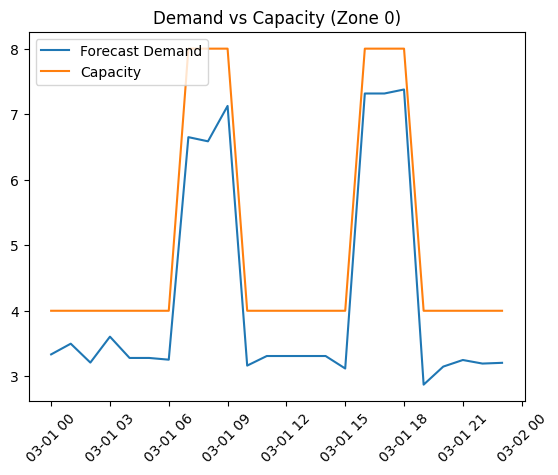

In [20]:
import matplotlib.pyplot as plt


sample_zone = 0

zone_data = future_df[future_df["zone_id"] == sample_zone].head(24)
zone_results = results_df[results_df["zone_id"] == sample_zone]

plt.figure()
plt.plot(zone_data["timestamp"], zone_data["forecast_orders"], label="Forecast Demand")
plt.plot(zone_data["timestamp"], zone_results["drivers"] * CAPACITY_PER_DRIVER, label="Capacity")
plt.legend()
plt.title("Demand vs Capacity (Zone 0)")
plt.xticks(rotation=45)
plt.show()

## Outputs

### Save Raw Orders

In [22]:
orders_df.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/data/raw/synthetic_orders.csv",
    index=False
)

### Save Hourly Demand

In [23]:
hourly_demand.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/data/processed/hourly_demand.csv",
    index=False
)

### Save Demand Forecasts

In [24]:
future_df.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/data/processed/demand_forecasts.csv",
    index=False
)

### Save Optimization Results

In [25]:
results_df.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/data/processed/optimization_results.csv",
    index=False
)

### Save KPI Summary

In [26]:
kpi_df = pd.DataFrame([kpis])
kpi_df.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/data/processed/kpis_summary.csv",
    index=False
)

### Create Executive Summary Table

In [28]:
exec_summary = {
    "Metric": [
        "Total Cost ($)",
        "Late Orders",
        "Driver Hours",
        "On-Time Delivery Rate"
    ],
    "Value": [
        kpis["total_cost"],
        kpis["late_orders"],
        kpis["driver_hours"],
        round(kpis["on_time_rate"], 3)
    ]
}

exec_df = pd.DataFrame(exec_summary)

exec_df.to_csv(
    "/Users/jonathan/git_repos/last_mile_optimization/outputs/tables/executive_summary.csv",
    index=False
)